In [1]:
import matplotlib.pyplot as plt
%matplotlib notebook

## draw entry road scenario

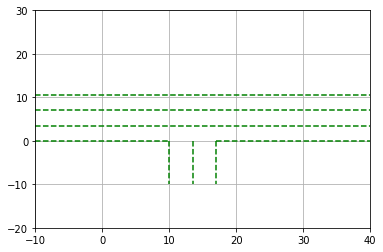

In [2]:
# draw road network
# roadSegs structure: {road_segment1:[[line1_x, line1_y],...],...}
roadSegs = {'road_segment1': [[-10, 10.5], [40, 10.5]],
            'road_segment2': [[-10, 7], [40, 7]],
            'road_segment3': [[-10, 3.5], [40, 3.5]],
            'road_segment4': [[-10, 0], [10, 0]],
            'road_segment5': [[17, 0], [40, 0]],
            'road_segment6': [[10, 0], [10, -10]],
            'road_segment7': [[13.5, 0], [13.5,-10]],
            'road_segment8': [[17, 0], [17, -10]]}

figure, ax = plt.subplots(1, 1)
x_min = -10
x_max = 40
y_min = -20
y_max = 30
ax.set_xlim(x_min, x_max)
ax.set_ylim(y_min, y_max)


for feature_id, lines in roadSegs.items():
    line_x = []
    line_y = []
    for line in lines:
        line_x.append(line[0])
        line_y.append(line[1])
    ax.plot(line_x, line_y, color='green', linestyle='dashed')

plt.grid(True)
plt.show()

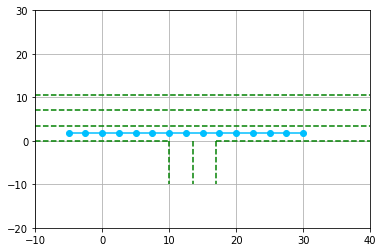

In [3]:
# draw car footprints
initial_pos = [30, 1.75]
vel = 2.5 # meter/sec
dt = 1.0 # sec
N = 15

car_footprints = []

car_width = 2.11
car_length = 5.93

for i in range(N):
    x_i = initial_pos[0] - vel * dt * i
    y_i = initial_pos[1]
    car_footprints.append([x_i, y_i])

figure, ax = plt.subplots(1, 1)
x_min = -10
x_max = 40
y_min = -20
y_max = 30
ax.set_xlim(x_min, x_max)
ax.set_ylim(y_min, y_max)


for feature_id, lines in roadSegs.items():
    line_x = []
    line_y = []
    for line in lines:
        line_x.append(line[0])
        line_y.append(line[1])
    ax.plot(line_x, line_y, color='green', linestyle='dashed')

footprint_x = []
footprint_y = []
for car_footprint in car_footprints:
    footprint_x.append(car_footprint[0])
    footprint_y.append(car_footprint[1])

plt.plot(footprint_x, footprint_y, color='deepskyblue', marker='o')
plt.grid(True)
plt.show()

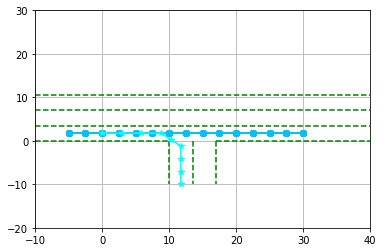

In [4]:
# draw car footprints
from scipy.interpolate import UnivariateSpline
from numpy import linspace

ego_initial_pos = [11.75, -10]
ego_turning_pos = [11.75, 1.75]
ego_target_pos = [0, 1.75]

ego_car_footprints = []

ego_car_width = 2.11
ego_car_length = 5.93

M = 10

x1 = linspace(ego_target_pos[0], ego_turning_pos[0], M//2)
y1 = linspace(ego_target_pos[1], ego_turning_pos[1], M//2)

x2 = linspace(ego_turning_pos[0], ego_initial_pos[0], M//2)
y2 = linspace(ego_turning_pos[1], ego_initial_pos[1], M//2)

for i in range(M//2-1):
    ego_car_footprints.append([x1[i], y1[i]])
    
ego_car_footprints.append([(x1[-2]+x2[1])/2, (y1[-2]+y2[1])/2])

for i in range(1, M//2):
    ego_car_footprints.append([x2[i], y2[i]])
ego_car_footprints.reverse()

figure, ax = plt.subplots(1, 1)
x_min = -10
x_max = 40
y_min = -20
y_max = 30
ax.set_xlim(x_min, x_max)
ax.set_ylim(y_min, y_max)

for feature_id, lines in roadSegs.items():
    line_x = []
    line_y = []
    for line in lines:
        line_x.append(line[0])
        line_y.append(line[1])
    ax.plot(line_x, line_y, color='green', linestyle='dashed')

ego_footprint_x = []
ego_footprint_y = []
for ego_car_footprint in ego_car_footprints:
    ego_footprint_x.append(ego_car_footprint[0])
    ego_footprint_y.append(ego_car_footprint[1])

    plt.plot(footprint_x, footprint_y, color='deepskyblue', marker='o')
plt.plot(ego_footprint_x, ego_footprint_y, color='cyan', marker='*')
plt.grid(True)
plt.show()

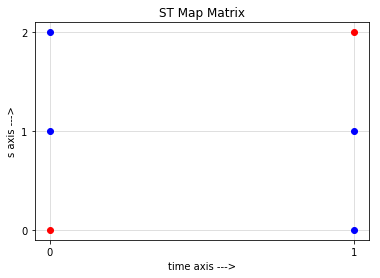

In [5]:
import numpy as np

def displayBinaryMatrix(matrix):
    figure, ax = plt.subplots(1, 1)
    plt.title('ST Map Matrix')
    plt.grid(True, alpha=0.5)
    plt.xlabel('time axis --->')
    plt.ylabel('s axis --->')
    
    x_dim = len(matrix)
    y_dim = len(matrix[0])
    
    ax.set_xticks(np.arange(0, x_dim, 1))
    ax.set_yticks(np.arange(0, y_dim, 1)) 
    
    for i in range(len(matrix)):
        for j in range(len(matrix[0])):
            if matrix[i][j]:
                plt.plot(i, j, 'ro')
            else:
                plt.plot(i, j, 'bo')

# test display binary matrix
matrix = [[1, 0, 0], [0, 0, 1]]
displayBinaryMatrix(matrix)

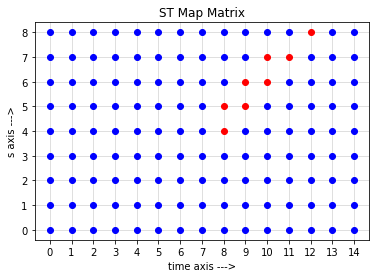

In [6]:
import math

def distance(pos1, pos2):
    return math.sqrt( ((pos1[0]-pos2[0])**2)+((pos1[1]-pos2[1])**2) )

def CollisionCheck(car1, car2):
    return distance(car1, car2) < 2.5

def STMapMatrix(s_poses, t_poses):
    st_matrix = []
    s_size = len(s_poses)
    t_size = len(t_poses)
    for t_pose in t_poses:
        tmp = []
        for s_pose in s_poses:
            tmp.append(CollisionCheck(t_pose, s_pose))
        st_matrix.append(tmp)
    return st_matrix
    
st_map_m = STMapMatrix(ego_car_footprints, car_footprints)
displayBinaryMatrix(st_map_m)

In [41]:
# velocity planning
def CostFunc(cur_vel, nxt_vel, cur_s, tar_s):
    weight1 = 5.0
    weight2 = 1.0
    return weight1 * (cur_vel - nxt_vel) ** 2 + weight2 * (cur_s - tar_s) ** 2

def SearchPlan(st_matrix, i, j, cur_vel, cur_cost, min_cost, cur_plan, best_plan):
    
    if j == len(s_vec)-1:
        if cur_cost < min_cost:
            min_cost = cur_cost
            best_plan = cur_plan[:]
        return min_cost, best_plan

    if i == len(t_vec)-1:
        return min_cost, best_plan
    
    if i == 0:
        cur_plan = [[0, 0]]
        cost_cost = 0.0
    
    n_search = 4
    for k in range(n_search):
        if i+1 < len(t_vec) and j+k < len(s_vec) and st_matrix[i+1][j+k] is False: # viable
            cur_plan.append([i+1, j+k])
            nxt_vel = (s_vec[j+k] - s_vec[j]) / dt
            cur_cost += CostFunc(cur_vel, nxt_vel, s_vec[j], s_vec[-1])
            min_cost, best_plan = SearchPlan(st_matrix, i+1, j+k, nxt_vel, cur_cost, min_cost, cur_plan, best_plan)
            cur_cost -= CostFunc(cur_vel, nxt_vel, s_vec[j], s_vec[-1])
            cur_plan.pop() # backtracking
            
    return min_cost, best_plan

def VelocityPlanner(st_matrix):
    cur_cost = 0.0
    min_cost = float("inf")
    cur_plan = []
    best_plan = []
    min_cost, best_plan = SearchPlan(st_matrix, 0, 0, init_vel, cur_cost, min_cost, cur_plan, best_plan)
    return min_cost, best_plan

# test search algorithm
init_vel = 2.0 # meters/sec
ds = 1.0
dt = 1.0 # sec
s_vec = [1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0]
t_vec = [0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 11.0, 12.0, 13.0, 14.0]

min_cost, best_plan = VelocityPlanner(st_map_m)
print(best_plan)

[[0, 0], [1, 3], [2, 6], [3, 8]]


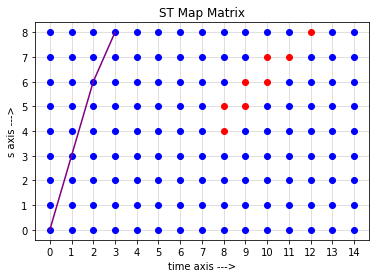

In [42]:
def displayVelocityPlan(matrix, plan):
    figure, ax = plt.subplots(1, 1)
    plt.title('ST Map Matrix')
    plt.grid(True, alpha=0.5)
    plt.xlabel('time axis --->')
    plt.ylabel('s axis --->')
    
    x_dim = len(matrix)
    y_dim = len(matrix[0])
    
    ax.set_xticks(np.arange(0, x_dim, 1))
    ax.set_yticks(np.arange(0, y_dim, 1)) 
    
    for i in range(len(matrix)):
        for j in range(len(matrix[0])):
            if matrix[i][j]:
                plt.plot(i, j, 'ro')
            else:
                plt.plot(i, j, 'bo')
                
    plan_x = []
    plan_y = []
    for entry in plan:
        plan_x.append(entry[0])
        plan_y.append(entry[1])
    plt.plot(plan_x, plan_y, color='purple')

# test display
displayVelocityPlan(st_map_m, best_plan)

In [43]:
# convert ot velocity list
vel_list = [init_vel]
for i in range(1, len(best_plan)):
    pre = best_plan[i-1][1]
    cur = best_plan[i][1]
    n = cur - pre
    for j in range(n):
        vel_list.append((s_vec[cur]-s_vec[pre])/dt)
    
print(vel_list)

[2.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 2.0, 2.0]
